[Click here for live site!](https://m-sender.github.io/notupyet)
<center><h1>Music Trends During the Pandemic</h1></center>
<center><b>Sam Broth and Max Sender</b></center>
<center>-------------------------------------------------------</center>

<center>1. Introduction</center>
<center>2. Data: Extraction, Transform and Load</center>
<center>3. Exploratory Data Analysis</center>
<center>4. Visualization</center>
<center>5. What it all means?</center>

<center><h1>1. Introduction</h1></center>

# Goals

# Our Data

# Questions and Hypothesis

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import scipy.stats as stats
#from scipy.interpolate import make_interp_spline
from functools import partial
#from lyricsgenius import Genius
#from dotenv import load_dotenv
#load_dotenv()
import sqlite3
#import nltk
#import spacy
#from spacytextblob.spacytextblob import SpacyTextBlob

<center><h1>2. Extraction, Transform and Load </h1></center>

We can do like 2.a, 2.b, etc for tidying and organizing and merging and such with explanations.

In [31]:

tracks_df = pd.read_csv("../datasets/tracks.csv")
artist_df = pd.read_csv("../datasets/artists.csv")
final_df = pd.read_csv("../datasets/Final database.csv")
full_df = pd.read_csv("../datasets/Database to calculate popularity.csv")



C:\Users\sambr\AppData\Local\Temp\ipykernel_5580\784403387.py:3: DtypeWarning: Columns (7,8,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  final_df = pd.read_csv("../datasets/Final database.csv")


# Explain Data sets

# Tidying up our data

In [32]:
full_df['date'] = pd.to_datetime(full_df['date'],dayfirst=True)
full_df['id'] = [x.split('/')[-1] if type(x)==str else float('nan') for x in full_df.uri.values]
f = partial(pd.to_datetime,yearfirst=True)
working_df = full_df[(full_df['date']>=f('01/01/2020')) & (full_df['date']<=f('06/30/2020'))].sort_values('date',ascending=False)
holder_df = working_df.merge(tracks_df,on='id',how='inner')

<center><h1>3. Exploratory Data Analysis</h1></center>


We break down our data analysis into 3 parts:
* (3.1) Analysis and Representation of Provided Metrics
* (3.2) NLP sentiment analysis of the lyrics per genre
* (3.3) Meshing the data together and pursuing further analysis
* (3.4) Covid-19 analysis with ____

<center><h3>3.1: Analysis and Representation of Provided Metrics</h3></center>

In [33]:
#Code for plotting graphs and metrics
def createMetricComparison(metricName,dataFrame,std=False): #change to zscore // streams per week (look)
    fig, ax = plt.subplots(1,2,figsize=(25,12), sharey=True, sharex=False)
    title = metricName[0].upper()+ metricName[1:] + ' Before and After Pandemic Begins'
    fig.suptitle(title,fontsize=16)

    

    #full_lyr[full_lyr['country']== 'USA'].plot.scatter(x='date',y='danceability', c='liveness',ax=ax)
    #group by dates, get scores for each in terms of danceability and apply weight, then sum, them plot
    #convert zscore = 
    if std:
        std_df = dataFrame[(dataFrame['date']<=f('03/10/2020')) & (dataFrame['date']>f('03/10/2020'))]
        dataFrame[metricName] = (dataFrame[metricName] - dataFrame[metricName].mean())/dataFrame[metricName].std()

    pre_pandemic = dataFrame[(dataFrame['date']<=f('03/10/2020')) & (holder_df['date'].dt.day % 7 == 0)]
    pandemic = dataFrame[(dataFrame['date']>f('03/10/2020'))  & (holder_df['date'].dt.day % 7 == 0)]
    pre_pandemic = pre_pandemic[pre_pandemic['country']=='USA']
    pandemic = pandemic[pandemic['country']=='USA']
  
    
    
    pp_groupby = pre_pandemic.groupby('date')[metricName].mean() 
    dp_groupby = pandemic.groupby('date')[metricName].mean() 
    #get zscore
    '''pp_groupby_z = (pp_groupby - pp_groupby.mean())/pp_groupby.std()
    dp_groupby_z = (dp_groupby - dp_groupby.mean())/dp_groupby.std()'''
    std_pre = pp_groupby.std()
    pp_groupby.plot(ax=ax[0],title='Before Pandemic',ylabel=metricName, xlabel='Date')
    dp_groupby.plot(ax=ax[1],title='After Pandemic Begins', xlabel='Date',ylabel=metricName)
    #plt.axhline(y=pp_groupby.mean(), color='r', linestyle='-')
    ax[0].hlines(y=pp_groupby.mean(), xmin="01-01-2020", xmax="03-10-2020", linewidth=2, color='r')
    ax[0].hlines(y=pp_groupby.mean()+std_pre, xmin="01-01-2020", xmax="03-10-2020", linewidth=2, color='y',linestyle='--')
    ax[0].hlines(y=pp_groupby.mean()-std_pre, xmin="01-01-2020", xmax="03-10-2020", linewidth=2, color='y',linestyle='--')
    
    #plt.axhline( y=dp_groupby.mean(), color='r', linestyle='-')
    ax[1].hlines(y=pp_groupby.mean()+std_pre, xmin="03-11-2020", xmax="06-30-2020", linewidth=2, color='y',linestyle='--')
    ax[1].hlines(y=pp_groupby.mean()-std_pre, xmin="03-11-2020", xmax="06-30-2020", linewidth=2, color='y',linestyle='--')
    
    ax[1].hlines(y=dp_groupby.mean(), xmin="03-11-2020", xmax="06-30-2020", linewidth=2, color='r')

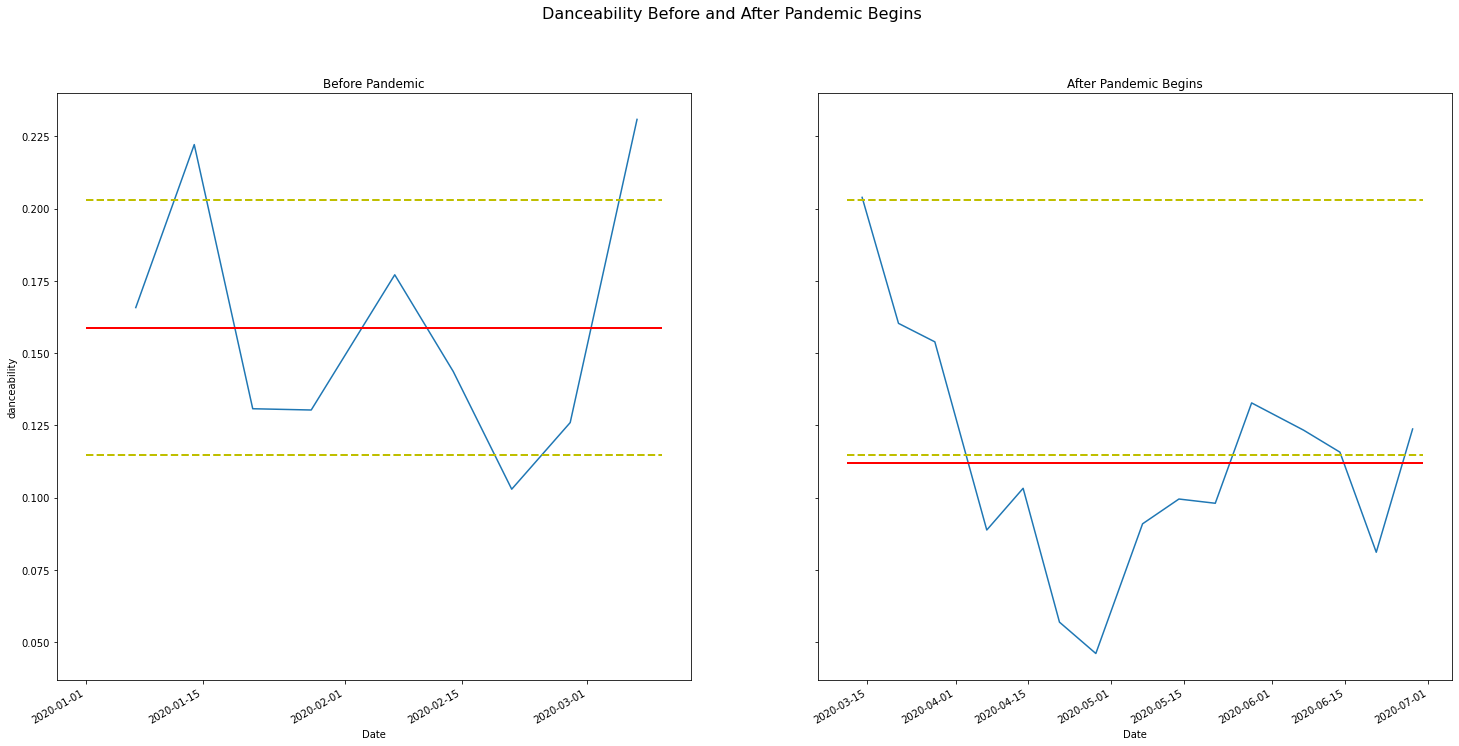

In [34]:
createMetricComparison('danceability',holder_df,std=True)

In [35]:
metric_list = ['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature','key','mode']
for metric in metric_list:
    #createMetricComparison(metric,holder_df)
    pass

<center><h3>3.2: NLP sentiment analysis of the lyrics per genre</h3></center>

In [36]:
conn = sqlite3.connect('../datasets/lyrics.db')
lyric_df = pd.read_sql_query("SELECT * FROM lyrics", conn)
lyric_df.rename(columns={'song':'title'},inplace=True)
pre_pandemic_lyr = working_df[(working_df['date']<=f('03/10/2020'))]# & (holder_df['date'].dt.day % 7 == 0)]
pandemic_lyr = working_df[(working_df['date']>f('03/10/2020'))]# & (holder_df['date'].dt.day % 7 == 0)]
full_lyr = pd.merge(pre_pandemic_lyr,pandemic_lyr,how='outer')
full_lyr = pd.merge(full_lyr,lyric_df,how='inner',on='uri')

In [37]:
for i in ['polarity','subjectivity','vader','vader_pos','vader_neg','vader_neut','sentiment']:
    #createMetricComparison(i,full_lyr,std=False)
    pass

Looking at these charts, interesting to see that neutrality decreased but the songs become more polarized as negative and postive both increased.

<center><h3>3.3: Meshing the data together and pursuing further analysis</h3></center>

##### Comparing _____ and ______ in order to show ____. #####

In [38]:
def make_graph(axel,dataFrame,metricName,country='USA',color='b',std=True,plot_std=False,avg=True,prePandem=True):  
    #get zscore
    
    #add logic for pre pandemic to display or not
    if std:#set to False if nono
        #df1 = dataFrame[(dataFrame['date']<=f('03/10/2020')) & (dataFrame['date']>f('03/10/2020'))]
        df1 = dataFrame
        df1[metricName] = (dataFrame[metricName] - dataFrame[metricName].mean())/dataFrame[metricName].std()
        pre_pandemic = df1[(dataFrame['date']<=f('03/10/2020'))  & (dataFrame['date'].dt.day % 7 == 0)]
        pandemic = df1[(dataFrame['date']>f('03/10/2020'))  & (dataFrame['date'].dt.day % 7 == 0)]
        pandemic = pandemic[(pandemic['date']<=f('06/30/2020'))]
        pp_groupby = pre_pandemic.groupby('date')[metricName].mean()
        dp_groupby = pandemic.groupby('date')[metricName].mean()
    else:
        pre_pandemic = dataFrame[(dataFrame['date']<=f('03/10/2020'))  & (dataFrame['date'].dt.day % 7 == 0)]
        pandemic = dataFrame[(dataFrame['date']>f('03/10/2020')) & (dataFrame['date'].dt.day % 7 == 0)]
        pandemic = pandemic[(pandemic['date']<=f('06/30/2020')) & (dataFrame['date'].dt.day % 7 == 0)]
        if country!=False:
            pre_pandemic = pre_pandemic[pre_pandemic['country']==country]
            pandemic = pandemic[pandemic['country']==country]
        pp_groupby = pre_pandemic.groupby('date')[metricName].mean() 
        dp_groupby = pandemic.groupby('date')[metricName].mean() 
    if plot_std:
        std_pre = pp_groupby.std()
        axel[0].hlines(y=pp_groupby.mean()+std_pre, xmin="01-01-2020", xmax="03-10-2020", linewidth=2, color=color,linestyle='--')
        axel[0].hlines(y=pp_groupby.mean()-std_pre, xmin="01-01-2020", xmax="03-10-2020", linewidth=2, color=color,linestyle='--')
        axel[1].hlines(y=pp_groupby.mean()+std_pre, xmin="03-11-2020", xmax="06-30-2020", linewidth=2, color=color,linestyle='--')
        axel[1].hlines(y=pp_groupby.mean()-std_pre, xmin="03-11-2020", xmax="06-30-2020", linewidth=2, color=color,linestyle='--')
    pp_groupby.plot(ax=axel[0],color=color,legend=True)
    dp_groupby.plot(ax=axel[1],color=color,legend=True)
    #plt.axhline(y=pp_groupby.mean(), color='r', linestyle='-')
    if avg:
        axel[0].hlines(y=pp_groupby.mean(), xmin="01-01-2020", xmax="03-10-2020", linewidth=2, color=color)    
        axel[1].hlines(y=dp_groupby.mean(), xmin="03-11-2020", xmax="06-30-2020", linewidth=2, color=color)
    #share code from below and make a function to makre graph and place it so can have mu,ltiple overlays
def zscoreTranslate(tupleList):
    new_df = tupleList[0][1][['date','country',tupleList[0][0]]]
    if len(tupleList) == 1:
        new_df[tupleList[0][0]] = (new_df[tupleList[0][0]] - new_df[tupleList[0][0]].mean())/new_df[tupleList[0][0]].std()
        return [(tupleList[0][0],new_df,tupleList[0][2])]
    temp = [tupleList[0][0]]
    for i in tupleList[1:]:
        temp.append(i[0])
        new_df = new_df.merge(i[1][['date',i[0]]],how='outer')
    new_df = new_df[temp].apply(lambda x: (x - x.min())/(x.max()-x.min()))
    #new_df = (new_df - new_df.mean()/new_df.std())
    for i in range(len(tupleList)):
        tupleList[i] = (tupleList[i][0],new_df,tupleList[i][2])
    return tupleList
    
    pass
def compare_Metrics(metric_df_tupleList,std,country,avg=True,prePandem=True):   #(metric1,metric2,df1,df2):
    #Code for plotting graphs and metrics
    #if std:
    #    metric_df_tupleList = zscoreTranslate(metric_df_tupleList) #remove to have per coloumn instead of overall(?? which doesnt seem to lke to run)
        
        #take df and metric, combine to 1 with dates, then get zscores
        
    fig, ax = plt.subplots(1,2,figsize=(25,12), sharey=True, sharex=False)
    title = "Comparison of "
    for i in metric_df_tupleList:
        title+= (i[0])[0].upper()+(i[0])[1:]+", and "
        make_graph(ax,i[1],i[0],color=i[2],std=std,plot_std=False,country=country,avg=avg,prePandem=prePandem)
    title = title[:-6]+  ' Before and After Pandemic Begins'
    fig.suptitle(title,fontsize=16)
    ax[1].set_xlabel('Date')
    ax[0].set_xlabel('Date')
    ax[0].title.set_text('Before Pandemic')
    ax[1].title.set_text('After Pandemic Begins')

    
    

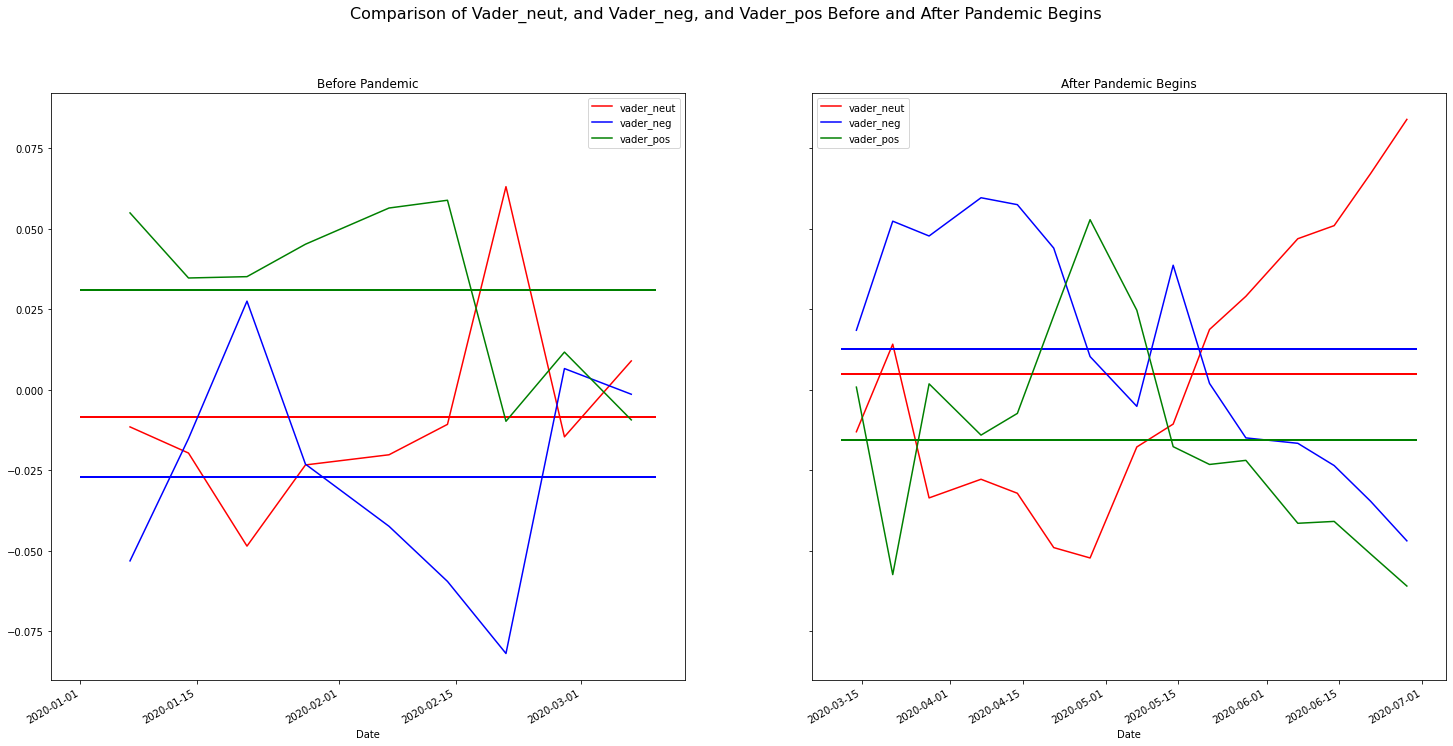

In [39]:
#display(compare_Metrics([('polarity',full_lyr, 'r')],std=True))
#display(compare_Metrics([('polarity',full_lyr, 'r'),('vader',full_lyr, 'b')],std=True,country=False,avg=True))
compare_Metrics([('vader_neut',full_lyr, 'r'),('vader_neg',full_lyr, 'b'),('vader_pos',full_lyr, 'g')],std=True,country='USA',avg=True)

<center><h3>3.4 Covid-19 analysis with ____</h3> </center>

In [40]:
#Load in Covid 19 US numbers
#and load in google trends data
covid_US = pd.read_csv('../datasets/us.csv')
covid_US_states = pd.read_csv('../datasets/us-states.csv')
covid_US['date'] = pd.to_datetime(covid_US['date'],dayfirst=True)
covid_US_states['date'] = pd.to_datetime(covid_US_states['date'],dayfirst=True)
covid_search = pd.read_csv('../datasets/covid_search.csv')
onlineTherapy_search = pd.read_csv('../datasets/onlineTherapy_search.csv')
symptoms_search = pd.read_csv('../datasets/symptoms_search.csv')
vaccine_search = pd.read_csv('../datasets/vaccine_search.csv')
searchTerm_df = covid_search.merge(onlineTherapy_search,how='outer',on='date').merge(symptoms_search,how='outer',on='date').merge(vaccine_search,how='outer',on='date')
searchTerm_df['date'] = pd.to_datetime(searchTerm_df['date'],dayfirst=True)
covid_US['new_cases'] = covid_US['cases'].diff()
covid_US['new_deaths'] = covid_US['deaths'].diff()


FileNotFoundError: [Errno 2] No such file or directory: '../datasets/covid_search.csv'

In [41]:
covid_US = covid_US.merge(full_lyr.groupby('date').mean(),how='outer',on='date')
covid_US = covid_US.merge(searchTerm_df,how='outer',on='date')
covid_US.drop(columns=['Unnamed: 0'],inplace=True)
holder_df = holder_df[holder_df['country']=='USA']
holder_df.drop(columns=['country','id','name','popularity','explicit','artists','id_artists','release_date'],inplace=True)
covid_US = covid_US.merge(holder_df,how='outer',on='date')
covid_US.drop(columns=['Unnamed: 0'],inplace=True)

NameError: name 'searchTerm_df' is not defined

<center><h1>4. Visualization</h1></center>

In [ ]:
#COVID-19 Analysis Sec

<center><h1>5. What it all means?</h1></center>

Conclusion